In [16]:
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import ToolNode
from dataclasses import dataclass, field
from typing import List, Dict, Optional, Any
from pydantic import BaseModel
from datetime import datetime, timedelta
from github import Github
import smtplib
from email.mime.text import MIMEText
from email.mime.multipart import MIMEMultipart
from jinja2 import Template
import os
import yaml
from typing import Dict, Any
from dotenv import load_dotenv

In [5]:
class EmailService:
    """Service for sending email notifications."""
    
    def __init__(self, smtp_host: str, smtp_port: int, username: str, password: str):
        self.smtp_host = smtp_host
        self.smtp_port = smtp_port
        self.username = username
        self.password = password
    
    def send_issue_alert(self, recipients: List[str], issues: List[Dict], 
                        repo_name: str, repo_url: str, threshold_days: int) -> bool:
        """Send email alert for issues that have been open beyond the threshold."""
        
        subject = f"[ALERT] Issues Open Beyond {threshold_days} Days - {repo_name}"
        
        # Create email content
        content = self._create_issue_alert_content(issues, repo_name, repo_url, threshold_days)
        
        return self._send_email(recipients, subject, content)
    
    def send_pr_notification(self, recipients: List[str], prs: List[Dict], 
                           repo_name: str, repo_url: str) -> bool:
        """Send email notification for recently merged pull requests."""
        
        subject = f"[UPDATE] Pull Requests Merged - {repo_name}"
        
        # Create email content
        content = self._create_pr_notification_content(prs, repo_name, repo_url)
        
        return self._send_email(recipients, subject, content)
    
    def _create_issue_alert_content(self, issues: List[Dict], repo_name: str, 
                                  repo_url: str, threshold_days: int) -> str:
        """Create HTML content for issue alert email."""
        
        template = Template("""
        <html>
        <head>
            <style>
                body { font-family: Arial, sans-serif; margin: 20px; }
                .header { background-color: #f44336; color: white; padding: 15px; border-radius: 5px; }
                .issue { border: 1px solid #ddd; margin: 10px 0; padding: 15px; border-radius: 5px; }
                .issue-title { font-weight: bold; color: #333; }
                .issue-meta { color: #666; font-size: 14px; margin-top: 5px; }
                .issue-link { color: #0366d6; text-decoration: none; }
                .repo-link { margin-top: 20px; }
            </style>
        </head>
        <body>
            <div class="header">
                <h2>🚨 Issues Open Beyond {{ threshold_days }} Days</h2>
                <p>Repository: {{ repo_name }}</p>
            </div>
            
            <p>The following issues have been open for more than <strong>{{ threshold_days }} days</strong> and may require attention:</p>
            
            {% for issue in issues %}
            <div class="issue">
                <div class="issue-title">
                    <a href="{{ issue.html_url }}" class="issue-link">#{{ issue.number }} - {{ issue.title }}</a>
                </div>
                <div class="issue-meta">
                    <strong>Age:</strong> {{ issue.age_days }} days<br>
                    <strong>Created:</strong> {{ issue.created_at.strftime('%Y-%m-%d %H:%M') }}<br>
                    <strong>Last Updated:</strong> {{ issue.updated_at.strftime('%Y-%m-%d %H:%M') }}<br>
                    {% if issue.labels %}
                    <strong>Labels:</strong> 
                    {% for label in issue.labels %}
                    <span style="background-color: #{{ label.color }}; color: white; padding: 2px 6px; border-radius: 3px; font-size: 12px;">{{ label.name }}</span>
                    {% endfor %}<br>
                    {% endif %}
                    {% if issue.assignees %}
                    <strong>Assignees:</strong> 
                    {% for assignee in issue.assignees %}
                    {{ assignee.login }}{% if not loop.last %}, {% endif %}
                    {% endfor %}
                    {% endif %}
                </div>
            </div>
            {% endfor %}
            
            <div class="repo-link">
                <a href="{{ repo_url }}" class="issue-link">View Repository on GitHub</a>
            </div>
            
            <hr>
            <p style="color: #666; font-size: 12px;">
                This email was sent by the Repository Monitor Agent on {{ datetime.now().strftime('%Y-%m-%d %H:%M:%S') }}
            </p>
        </body>
        </html>
        """)
        
        return template.render(
            issues=issues,
            repo_name=repo_name,
            repo_url=repo_url,
            threshold_days=threshold_days,
            datetime=datetime
        )
    
    def _create_pr_notification_content(self, prs: List[Dict], repo_name: str, repo_url: str) -> str:
        """Create HTML content for PR notification email."""
        
        template = Template("""
        <html>
        <head>
            <style>
                body { font-family: Arial, sans-serif; margin: 20px; }
                .header { background-color: #28a745; color: white; padding: 15px; border-radius: 5px; }
                .pr { border: 1px solid #ddd; margin: 10px 0; padding: 15px; border-radius: 5px; }
                .pr-title { font-weight: bold; color: #333; }
                .pr-meta { color: #666; font-size: 14px; margin-top: 5px; }
                .pr-link { color: #0366d6; text-decoration: none; }
                .repo-link { margin-top: 20px; }
                .merged { border-left: 4px solid #28a745; }
                .closed { border-left: 4px solid #dc3545; }
            </style>
        </head>
        <body>
            <div class="header">
                <h2>🔄 Recent Pull Request Activity</h2>
                <p>Repository: {{ repo_name }}</p>
            </div>
            
            <p>The following pull requests were recently processed:</p>
            
            {% for pr in prs %}
            <div class="pr {% if pr.merged_at %}merged{% elif pr.closed_at %}closed{% endif %}">
                <div class="pr-title">
                    <a href="{{ pr.html_url }}" class="pr-link">#{{ pr.number }} - {{ pr.title }}</a>
                </div>
                <div class="pr-meta">
                    <strong>Status:</strong> 
                    {% if pr.merged_at %}
                    <span style="color: #28a745;">✅ Merged</span>
                    {% elif pr.closed_at %}
                    <span style="color: #dc3545;">❌ Closed</span>
                    {% else %}
                    <span style="color: #ffc107;">⏳ Open</span>
                    {% endif %}<br>
                    {% if pr.merged_at %}
                    <strong>Merged:</strong> {{ pr.merged_at.strftime('%Y-%m-%d %H:%M') }}<br>
                    {% elif pr.closed_at %}
                    <strong>Closed:</strong> {{ pr.closed_at.strftime('%Y-%m-%d %H:%M') }}<br>
                    {% endif %}
                    {% if pr.labels %}
                    <strong>Labels:</strong> 
                    {% for label in pr.labels %}
                    <span style="background-color: #{{ label.color }}; color: white; padding: 2px 6px; border-radius: 3px; font-size: 12px;">{{ label.name }}</span>
                    {% endfor %}<br>
                    {% endif %}
                    {% if pr.assignees %}
                    <strong>Assignees:</strong> 
                    {% for assignee in pr.assignees %}
                    {{ assignee.login }}{% if not loop.last %}, {% endif %}
                    {% endfor %}
                    {% endif %}
                </div>
            </div>
            {% endfor %}
            
            <div class="repo-link">
                <a href="{{ repo_url }}" class="pr-link">View Repository on GitHub</a>
            </div>
            
            <hr>
            <p style="color: #666; font-size: 12px;">
                This email was sent by the Repository Monitor Agent on {{ datetime.now().strftime('%Y-%m-%d %H:%M:%S') }}
            </p>
        </body>
        </html>
        """)
        
        return template.render(
            prs=prs,
            repo_name=repo_name,
            repo_url=repo_url,
            datetime=datetime
        )
    
    def _send_email(self, recipients: List[str], subject: str, content: str) -> bool:
        """Send email using SMTP."""
        try:
            msg = MIMEMultipart('alternative')
            msg['Subject'] = subject
            msg['From'] = self.username
            msg['To'] = ', '.join(recipients)
            
            # Attach HTML content
            html_part = MIMEText(content, 'html')
            msg.attach(html_part)
            
            # Send email
            with smtplib.SMTP(self.smtp_host, self.smtp_port) as server:
                server.starttls()
                server.login(self.username, self.password)
                server.send_message(msg)
            
            return True
            
        except Exception as e:
            print(f"Failed to send email: {e}")
            return False 

In [7]:
@dataclass
class RepoMonitorState:
    """State for the repository monitoring workflow."""
    
    # Repository configuration
    repo_owner: str
    repo_name: str
    github_token: str
    
    # Monitoring configuration
    issue_threshold_days: int = 7
    email_recipients: List[str] = field(default_factory=list)
    
    # Current repository state
    open_issues: List[Dict] = field(default_factory=list)
    recent_prs: List[Dict] = field(default_factory=list)
    
    # Email tracking
    last_email_sent: Optional[datetime] = None
    sent_notifications: List[str] = field(default_factory=list)
    
    # Email configuration
    smtp_host: str = "smtp.gmail.com"
    smtp_port: int = 587
    email_username: str = ""
    email_password: str = ""
    
    # Workflow state
    should_send_issue_alert: bool = False
    should_send_pr_notification: bool = False
    alert_issues: List[Dict] = field(default_factory=list)
    notification_prs: List[Dict] = field(default_factory=list)

class Issue(BaseModel):
    """GitHub issue model."""
    number: int
    title: str
    state: str
    created_at: datetime
    updated_at: datetime
    html_url: str
    labels: List[Dict] = []
    assignees: List[Dict] = []
    
    @property
    def age_days(self) -> int:
        """Calculate how many days the issue has been open."""
        return (datetime.now() - self.created_at).days


class PullRequest(BaseModel):
    """GitHub pull request model."""
    number: int
    title: str
    state: str
    merged_at: Optional[datetime]
    closed_at: Optional[datetime]
    html_url: str
    labels: List[Dict] = []
    assignees: List[Dict] = []
    
    @property
    def is_merged(self) -> bool:
        """Check if the PR was merged."""
        return self.merged_at is not None 

In [8]:
class GitHubClient:
    """Client for interacting with GitHub API."""
    
    def __init__(self, token: str):
        self.github = Github(token)
    
    def get_open_issues(self, owner: str, repo_name: str) -> List[Issue]:
        """Fetch all open issues from a repository."""
        repo = self.github.get_repo(f"{owner}/{repo_name}")
        issues = []
        
        for issue in repo.get_issues(state='open'):
            issue_data = Issue(
                number=issue.number,
                title=issue.title,
                state=issue.state,
                created_at=issue.created_at,
                updated_at=issue.updated_at,
                html_url=issue.html_url,
                labels=[{"name": label.name, "color": label.color} for label in issue.labels],
                assignees=[{"login": assignee.login, "avatar_url": assignee.avatar_url} for assignee in issue.assignees]
            )
            issues.append(issue_data)
        
        return issues
    
    def get_recent_prs(self, owner: str, repo_name: str, lookback_hours: int = 24) -> List[PullRequest]:
        """Fetch recently merged or closed pull requests."""
        repo = self.github.get_repo(f"{owner}/{repo_name}")
        prs = []
        
        # Calculate the lookback time
        lookback_time = datetime.now() - timedelta(hours=lookback_hours)
        
        for pr in repo.get_pulls(state='all'):
            # Only include PRs that were merged or closed within the lookback period
            if pr.merged_at and pr.merged_at >= lookback_time:
                pr_data = PullRequest(
                    number=pr.number,
                    title=pr.title,
                    state=pr.state,
                    merged_at=pr.merged_at,
                    closed_at=pr.closed_at,
                    html_url=pr.html_url,
                    labels=[{"name": label.name, "color": label.color} for label in pr.labels],
                    assignees=[{"login": assignee.login, "avatar_url": assignee.avatar_url} for assignee in pr.assignees]
                )
                prs.append(pr_data)
            elif pr.closed_at and pr.closed_at >= lookback_time and not pr.merged_at:
                # Include closed but not merged PRs
                pr_data = PullRequest(
                    number=pr.number,
                    title=pr.title,
                    state=pr.state,
                    merged_at=pr.merged_at,
                    closed_at=pr.closed_at,
                    html_url=pr.html_url,
                    labels=[{"name": label.name, "color": label.color} for label in pr.labels],
                    assignees=[{"login": assignee.login, "avatar_url": assignee.avatar_url} for assignee in pr.assignees]
                )
                prs.append(pr_data)
        
        return prs
    
    def get_repo_info(self, owner: str, repo_name: str) -> Dict:
        """Get basic repository information."""
        repo = self.github.get_repo(f"{owner}/{repo_name}")
        return {
            "name": repo.name,
            "full_name": repo.full_name,
            "description": repo.description,
            "html_url": repo.html_url,
            "open_issues_count": repo.open_issues_count,
            "stargazers_count": repo.stargazers_count,
            "forks_count": repo.forks_count
        } 

In [22]:

class RepoMonitorWorkflow:
    """LangGraph workflow for repository monitoring."""
    
    def __init__(self, config: Dict[str, Any]):
        self.config = config
        self.github_client = GitHubClient(config['repository']['token'])
        self.email_service = EmailService(
            config['email']['smtp_host'],
            config['email']['smtp_port'],
            config['email']['username'],
            config['email']['password']
        )
        
        # Create the workflow graph
        self.workflow = self._create_workflow()
    
    def _create_workflow(self) -> StateGraph:
        """Create the LangGraph workflow."""
        
        # Create the state graph
        workflow = StateGraph(RepoMonitorState)
        
        # Add nodes
        workflow.add_node("fetch_data", self._fetch_data_node)
        workflow.add_node("analyze_issues", self._analyze_issues_node)
        workflow.add_node("analyze_prs", self._analyze_prs_node)
        workflow.add_node("send_issue_alert", self._send_issue_alert_node)
        workflow.add_node("send_pr_notification", self._send_pr_notification_node)
        workflow.add_node("update_state", self._update_state_node)
        
        # Define the workflow edges
        workflow.set_entry_point("fetch_data")
        
        # After fetching data, analyze both issues and PRs
        workflow.add_edge("fetch_data", "analyze_issues")
        workflow.add_edge("fetch_data", "analyze_prs")
        
        # Conditional edges based on analysis results
        workflow.add_conditional_edges(
            "analyze_issues",
            self._should_send_issue_alert,
            {
                "send_alert": "send_issue_alert",
                "skip": "update_state"
            }
        )
        
        workflow.add_conditional_edges(
            "analyze_prs",
            self._should_send_pr_notification,
            {
                "send_notification": "send_pr_notification",
                "skip": "update_state"
            }
        )
        
        # After sending emails, update state
        workflow.add_edge("send_issue_alert", "update_state")
        workflow.add_edge("send_pr_notification", "update_state")
        
        # End the workflow
        workflow.add_edge("update_state", END)
        
        return workflow.compile()
    
    def _fetch_data_node(self, state: RepoMonitorState) -> RepoMonitorState:
        """Fetch current repository data."""
        print(f"Fetching data for {state.repo_owner}/{state.repo_name}...")
        
        # Fetch open issues
        issues = self.github_client.get_open_issues(state.repo_owner, state.repo_name)
        state.open_issues = [issue.dict() for issue in issues]
        
        # Fetch recent PRs
        prs = self.github_client.get_recent_prs(
            state.repo_owner, 
            state.repo_name, 
            self.config['monitoring']['pr_lookback_hours']
        )
        state.recent_prs = [pr.dict() for pr in prs]
        
        print(f"Found {len(state.open_issues)} open issues and {len(state.recent_prs)} recent PRs")
        return state
    
    def _analyze_issues_node(self, state: RepoMonitorState) -> RepoMonitorState:
        """Analyze issues to determine if alerts should be sent."""
        print("Analyzing issues for alerts...")
        
        # Find issues that exceed the threshold
        alert_issues = []
        for issue_data in state.open_issues:
            issue = Issue(**issue_data)
            if issue.age_days >= state.issue_threshold_days:
                alert_issues.append(issue_data)
        
        state.alert_issues = alert_issues
        state.should_send_issue_alert = len(alert_issues) > 0
        
        print(f"Found {len(alert_issues)} issues that exceed the {state.issue_threshold_days}-day threshold")
        return state
    
    def _analyze_prs_node(self, state: RepoMonitorState) -> RepoMonitorState:
        """Analyze PRs to determine if notifications should be sent."""
        print("Analyzing PRs for notifications...")
        
        # Find PRs that were recently merged or closed
        notification_prs = []
        for pr_data in state.recent_prs:
            pr = PullRequest(**pr_data)
            if pr.is_merged or pr.closed_at:
                notification_prs.append(pr_data)
        
        state.notification_prs = notification_prs
        state.should_send_pr_notification = len(notification_prs) > 0
        
        print(f"Found {len(notification_prs)} PRs that were recently processed")
        return state
    
    def _should_send_issue_alert(self, state: RepoMonitorState) -> str:
        """Determine if issue alert should be sent."""
        return "send_alert" if state.should_send_issue_alert else "skip"
    
    def _should_send_pr_notification(self, state: RepoMonitorState) -> str:
        """Determine if PR notification should be sent."""
        return "send_notification" if state.should_send_pr_notification else "skip"
    
    def _send_issue_alert_node(self, state: RepoMonitorState) -> RepoMonitorState:
        """Send issue alert email."""
        print("Sending issue alert email...")
        
        repo_url = f"https://github.com/{state.repo_owner}/{state.repo_name}"
        
        success = self.email_service.send_issue_alert(
            recipients=state.email_recipients,
            issues=state.alert_issues,
            repo_name=state.repo_name,
            repo_url=repo_url,
            threshold_days=state.issue_threshold_days
        )
        
        if success:
            print("Issue alert email sent successfully")
            state.sent_notifications.append(f"issue_alert_{datetime.now().isoformat()}")
        else:
            print("Failed to send issue alert email")
        
        return state
    
    def _send_pr_notification_node(self, state: RepoMonitorState) -> RepoMonitorState:
        """Send PR notification email."""
        print("Sending PR notification email...")
        
        repo_url = f"https://github.com/{state.repo_owner}/{state.repo_name}"
        
        success = self.email_service.send_pr_notification(
            recipients=state.email_recipients,
            prs=state.notification_prs,
            repo_name=state.repo_name,
            repo_url=repo_url
        )
        
        if success:
            print("PR notification email sent successfully")
            state.sent_notifications.append(f"pr_notification_{datetime.now().isoformat()}")
        else:
            print("Failed to send PR notification email")
        
        return state
    
    def _update_state_node(self, state: RepoMonitorState) -> RepoMonitorState:
        """Update workflow state after processing."""
        print("Updating workflow state...")
        
        # Update last email sent time if any emails were sent
        if state.sent_notifications:
            state.last_email_sent = datetime.now()
        
        # Reset workflow flags
        state.should_send_issue_alert = False
        state.should_send_pr_notification = False
        state.alert_issues = []
        state.notification_prs = []
        
        print("Workflow completed successfully")
        return state
    
    def run(self, initial_state: RepoMonitorState) -> RepoMonitorState:
        """Run the workflow with the given initial state."""
        return self.workflow.invoke(initial_state) 
    
    def show_graph(xray=False):
        """Display a LangGraph mermaid diagram with fallback rendering.
        
        Handles timeout errors from mermaid.ink by falling back to pyppeteer.
        
        Args:
            graph: The LangGraph object that has a get_graph() method
        """
        from IPython.display import Image
        try:
            # Try the default renderer first
            return Image(workflow.workflow.get_graph(xray=xray).draw_mermaid_png())
        except Exception as e:
            # Fall back to pyppeteer if the default renderer fails
            import nest_asyncio
            nest_asyncio.apply()
            from langchain_core.runnables.graph import MermaidDrawMethod
            return Image(workflow.workflow.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.PYPPETEER))
    

In [23]:
class ConfigManager:
    """Manages configuration loading and environment variable substitution."""
    
    def __init__(self, config_path: str = "config.yaml"):
        self.config_path = config_path
        load_dotenv()  # Load environment variables from .env file
    
    def load_config(self) -> Dict[str, Any]:
        """Load configuration from YAML file with environment variable substitution."""
        if not os.path.exists(self.config_path):
            raise FileNotFoundError(f"Configuration file not found: {self.config_path}")
        
        with open(self.config_path, 'r') as file:
            config = yaml.safe_load(file)
        
        # Substitute environment variables
        config = self._substitute_env_vars(config)
        
        # Validate configuration
        self._validate_config(config)
        
        return config
    
    def _substitute_env_vars(self, obj: Any) -> Any:
        """Recursively substitute environment variables in configuration values."""
        if isinstance(obj, dict):
            return {key: self._substitute_env_vars(value) for key, value in obj.items()}
        elif isinstance(obj, list):
            return [self._substitute_env_vars(item) for item in obj]
        elif isinstance(obj, str) and obj.startswith("${") and obj.endswith("}"):
            env_var = obj[2:-1]  # Remove ${ and }
            value = os.getenv(env_var)
            if value is None:
                raise ValueError(f"Environment variable {env_var} not found")
            return value
        else:
            return obj
    
    def _validate_config(self, config: Dict[str, Any]) -> None:
        """Validate the configuration structure and required fields."""
        required_sections = ['repository', 'monitoring', 'email']
        
        for section in required_sections:
            if section not in config:
                raise ValueError(f"Missing required configuration section: {section}")
        
        # Validate repository section
        repo_config = config['repository']
        required_repo_fields = ['owner', 'name', 'token']
        for field in required_repo_fields:
            if field not in repo_config:
                raise ValueError(f"Missing required repository field: {field}")
        
        # Validate monitoring section
        monitoring_config = config['monitoring']
        required_monitoring_fields = ['issue_threshold_days', 'check_interval_hours', 'pr_lookback_hours']
        for field in required_monitoring_fields:
            if field not in monitoring_config:
                raise ValueError(f"Missing required monitoring field: {field}")
        
        # Validate email section
        email_config = config['email']
        required_email_fields = ['smtp_host', 'smtp_port', 'username', 'password', 'recipients']
        for field in required_email_fields:
            if field not in email_config:
                raise ValueError(f"Missing required email field: {field}")
        
        # Validate data types
        if not isinstance(monitoring_config['issue_threshold_days'], int):
            raise ValueError("issue_threshold_days must be an integer")
        
        if not isinstance(monitoring_config['check_interval_hours'], int):
            raise ValueError("check_interval_hours must be an integer")
        
        if not isinstance(monitoring_config['pr_lookback_hours'], int):
            raise ValueError("pr_lookback_hours must be an integer")
        
        if not isinstance(email_config['smtp_port'], int):
            raise ValueError("smtp_port must be an integer")
        
        if not isinstance(email_config['recipients'], list):
            raise ValueError("recipients must be a list")
        
        if not email_config['recipients']:
            raise ValueError("At least one email recipient must be specified")
    
    def create_initial_state(self, config: Dict[str, Any]) -> 'RepoMonitorState':
        """Create initial state from configuration."""
        from .state import RepoMonitorState
        
        return RepoMonitorState(
            repo_owner=config['repository']['owner'],
            repo_name=config['repository']['name'],
            github_token=config['repository']['token'],
            issue_threshold_days=config['monitoring']['issue_threshold_days'],
            email_recipients=config['email']['recipients'],
            smtp_host=config['email']['smtp_host'],
            smtp_port=config['email']['smtp_port'],
            email_username=config['email']['username'],
            email_password=config['email']['password']
        ) 

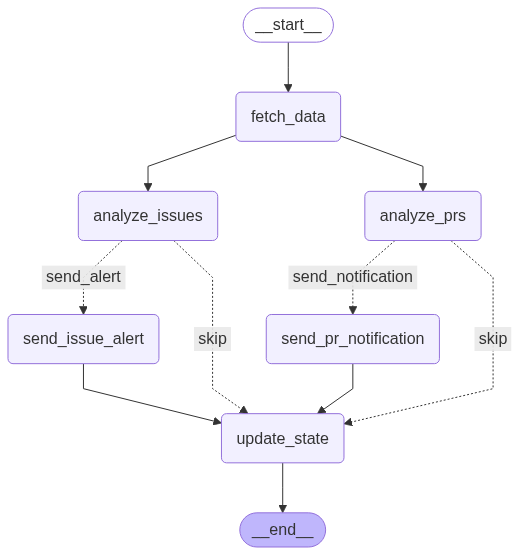

In [24]:
config_manager = ConfigManager()
config = config_manager.load_config()

# Create workflow and initial state
workflow = RepoMonitorWorkflow(config)
workflow.show_graph()